# Classifying Rap Songs with K-Means Clustering

This task is an attempt to classify an unlabeled dataset of rap songs into groups based on their lyrics.

In [6]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn')

In [7]:
#load file
df = pd.read_csv(r"rap_songs.csv").convert_dtypes()
df.head()

,artist,title,album,year,lyrics,label,writers
0,2Pac,Hit 'Em Up,Greatest Hits,1996,I ain't got no motherfuckin' friends That's wh...,Death Row Records & Interscope Records,"Johnny J', 'Yaki Kadafi', 'E.D.I. Mean', 'Huss..."
1,2Pac,Changes,Greatest Hits,1998,"Ooh, yeah (Ooh) (Come on, come on) I see no c...","Amaru Entertainment, Death Row Records & Inter...","Bruce Hornsby', 'Big D The Impossible', '2Pac'"
2,2Pac,Keep Ya Head Up,Strictly 4 My N.I.G.G.A.Z...,1993,Little something for my godson Elijah And a li...,Interscope Records,"Stan Vincent', 'Roger Troutman', 'DJ Daryl', '..."
3,2Pac,Hail Mary,The Don Killuminati: The 7 Day Theory,1997,"Makaveli in this, Killuminati All through your...",Death Row Records & Interscope Records,"2Pac', 'Hussein Fatal', 'Hurt-M-Badd', 'Prince..."
4,2Pac,Dear Mama,Me Against the World,1995,"You are appreciated When I was young, me and m...","Interscope Records, Out Da Gutta Records & Atl...","2Pac', 'Tony Pizarro', 'Joe Sample', 'Terrence..."


In [8]:
#Cleaning up unwanted symbols in dataset features
df['writers'] = df['writers'].str.replace("'", "")
df['lyrics'] = df['lyrics'].str.replace('\n', ' ') #remove line breaks
df['lyrics'] = df['lyrics'].str.replace('(', '')
df['lyrics'] = df['lyrics'].str.replace(')', '')
df['lyrics'] = df['lyrics'].str.lower()
df = df.dropna(subset = ['lyrics'])
df['lyrics'].sample(5)

10115    ok, alright, alright. you got me up? is the mi...
6557     ayo, this is no lie-ie-ie me and my niggas get...
10668    now i haven't eaten all day. how am i gonna do...
9406     yeah, legendary swag, young god, stay drippin'...
6124     clarity... clarity...  clarity figure all this...
Name: lyrics, dtype: string

In [9]:
#Find word counts
df['word_count'] = df['lyrics'].apply(lambda x: len(str(x).split(" ")))
df[['title','word_count']].head()

,title,word_count
0,Hit 'Em Up,1146
1,Changes,891
2,Keep Ya Head Up,866
3,Hail Mary,924
4,Dear Mama,705


Ranking artists by average words per song.

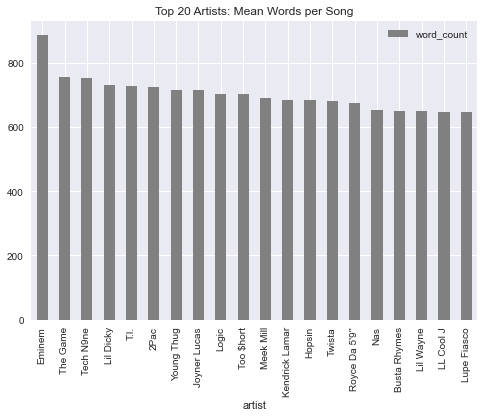

In [10]:
avg = df.groupby(['artist'])['word_count'].mean().reset_index()
avg.sort_values('word_count', ascending = False)[:20].plot(kind = 'bar', x ='artist', color='grey', title='Top 20 Artists: Mean Words per Song')

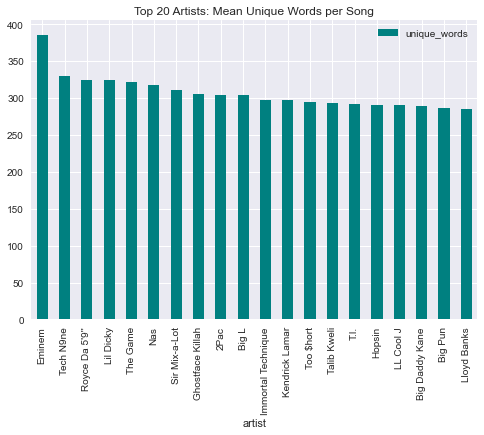

In [11]:
df['unique_words'] = df['lyrics'].apply(lambda x: len(set(str(x).split(" "))))
avg_unique = df.groupby(['artist'])['unique_words'].mean().reset_index()
avg_unique.sort_values('unique_words', ascending = False)[:20].plot(kind = 'bar', x ='artist', color='teal', title='Top 20 Artists: Mean Unique Words per Song')

## CorpusPreprocessing

The first step in processing text data is to lemmatize all words. Lemmatization means to convert all words into their root words, for example, "waiting" is changed to "wait." This ensures words in diffrent forms are all grouped as one and not counted as multiple features. 

In the NLTK library, the WordNetLemmatizer functions more accurately when Parts of Speech (POS) tags are added to each word. The tag identifies each word as a noun, verb, adjective, or etc based on its definition and context of the sentence.. 

In [12]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

#converting nltk tag to wordnet tag
def nltk_to_wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lem(doc):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(doc))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_to_wn_tag(x[1])), nltk_tagged)
    lem_sent = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lem_sent.append(word)
        else:        
            #else use the tag to lemmatize the token
            lem_sent.append(wnl.lemmatize(word, tag))
    return " ".join(lem_sent)

df['lyrics_lem'] = df.apply(lambda x: lem(x['lyrics']), axis = 1)    

Next is to remove words and symbols that do not contribute or may skew the classification process. 

In [13]:
#clean lyrics
import string
import re
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
punc = set(string.punctuation)

def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop]) #removing stopwords
    punc_free = ''.join(ch for ch in stop_free if ch not in punc) #removing punctuation
    no_letternum = re.sub("\S*\d\S*"," ", punc_free) #remove words with letter and number combinations
    num_free = ''.join([i for i in no_letternum if not i.isdigit()]) #remove numbers
    single_free = ' '.join(word for word in num_free.split() if len(word)>2) #remove words with 2 characters or less
    return single_free

df['lyrics_clean'] = df.apply(lambda x: clean(x['lyrics_lem']), axis = 1)    

## Term Frequency
After cleaning the lyrics, we can now perform some analysis on the frequency of terms across the songs in the dataset.

Converting the lyrics into tokens and calculating frequency distribution.

In [14]:
freq_dists, total_words = [], []
# Tokenize the song lyrics
tokens = df.lyrics_clean.str.split(expand =True).stack()

# Calculate word frequencies
freq_dists.append(nltk.FreqDist(tokens))
    
# Calculate total number of words
all_words = []
for lyrics in df.lyrics_clean:
    all_words.extend(lyrics.split(' '))
total_words.append(len(all_words))

Plotting the most used words after lemmatization and cleaning.

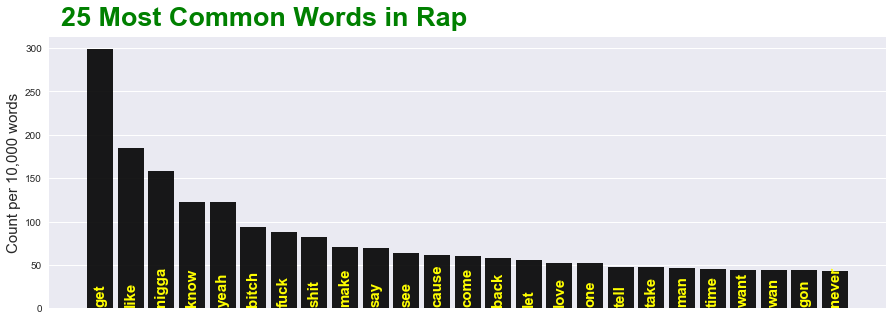

In [15]:
num_words = 25
FS = 20
fig, axs = plt.subplots(nrows=len(freq_dists), figsize=(15, 5), sharex=True)
words, counts = zip(*[(word,count) for word, count in freq_dists[0].most_common(num_words)])
idxs = np.arange(num_words)

# Normalize to 'Usage per 10,000 words'
counts = 10000*(np.asarray(counts)/total_words)

axs.bar(idxs, counts, width=0.85, color='black', alpha=0.9)
axs.set_ylabel('Count per 10,000 words', fontsize=FS-5)
axs.set_xticks([])
axs.grid(True)

# Adding song words to the plot
params = {'fontsize': FS-5, 'rotation':90, 'va':'bottom', 'ha':'center',
              'color':'yellow', 'alpha':1, 'weight':'heavy'}
for idx, word in zip(idxs, words):
    axs.text(idx, 2.6, word, fontdict=params)

y = axs.get_ylim()[1]
x = idxs[-1]*1.04    
xlim = axs.get_xlim()
mid = np.mean(xlim)
params_title = {'fontsize': FS+7, 'weight': 'heavy', 'ha': 'right', 'va':'bottom',
              'alpha': 1, 'color':'green', 'zorder':500}  
axs.set_title("25 Most Common Words in Rap", fontdict=params_title)

plt.show()

We can now transform the tokenized lyrics into a Term Frequency-Inverse Document Frequency (TF-IDF) vector. This assigns a statistical weight to each word based on its importance relative to its document, or in this case, its song.

One particular feature in the TFIDF vectorizer is to adjust the minimum and maximum document frequency of words to be included. This helps in removing words that are either too common or too rare, which may not contribute to the variation of the lyrics. The unique words to be included in our model appear in at least 2% and no more than 50% of the songs.

In [16]:
#Transforming words in lyrics into a TFIDF vector
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.5) 
X = vectorizer.fit_transform(df['lyrics_clean']).toarray()
X.shape

(19027, 1294)

Since we are dealing with a very wide dataset of 1294 features, reducing dimensionality with Principal Component Analysis may be helpful prior to training a model on it. Plotting a chart that visualizes the cumulative explained variance can help determine an acceptable number of features to use.

Text(0, 0.5, 'cumulative explained variance')

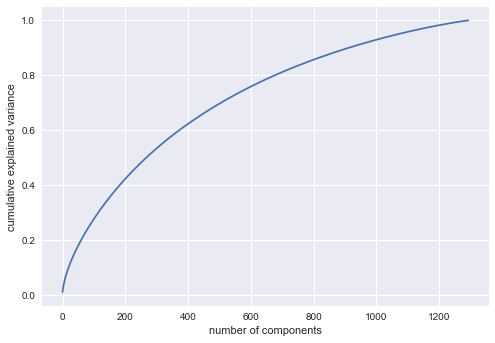

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
#Plotting variance and number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We will use 500 features, as it accounts for about 70% of the total variance in the dataset.

In [18]:
n_feat = 500
pca_2 = PCA(n_components = n_feat)
X_2 = pca_2.fit_transform(X)
X_2.shape

(19027, 500)

## Clustering using K-Means and Determining Number of Clusters

The dataset is now ready to be fitted to a model. We will use the K-Means clustering model to try to classify the songs. Since there are no existing cluster labels, the K-Means model will be performing unsupervised learning to find patterns in the TFIDF vector and group similar songs together.

With no existing target labels, we will have to determine the amount of clusters for the model to group the songs into. One solution is to use the "elbow method." This method plots a chart the sum of squared distances (also known as inertia) of the vector points by the number of clusters used. We then observe the point where the inertia ceases to decrease to determine the optimal number of clusters. This point is known as the "elbow." Plotting the euclidean distance (distortion) yields the same result.

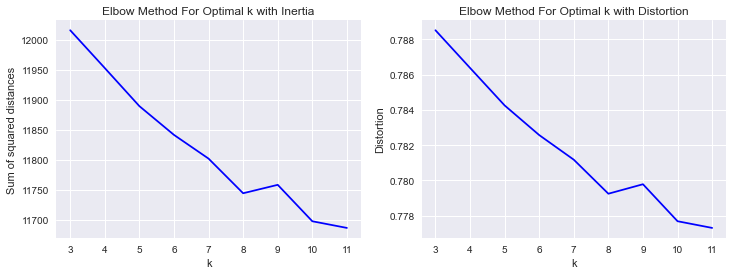

In [71]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
Sum_of_squared_distances, distortions = [], []
K = range(3,12)
for k in K:
    km = KMeans(n_clusters=k, max_iter=300, n_init=1, algorithm = 'full', random_state=3)
    km = km.fit(X_2)
    Sum_of_squared_distances.append(km.inertia_)
    distortions.append(sum(np.min(cdist(X_2, km.cluster_centers_, 'euclidean'),axis=1)) / X_2.shape[0]) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of squared distances')
ax1.set_title('Elbow Method For Optimal k with Inertia')

ax2.plot(K, distortions, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Distortion')
ax2.set_title('Elbow Method For Optimal k with Distortion')

plt.show()

As we can see in the two elbow methods, 8 clusters seems to be the optimal amount. The sum of squared distance and distortion begins to decrease at a slower rate after 8 clusters. However, distortion and inertia do not describe the individual quality of the clusters, such as the amount of overlap and separability. Another method to determine the optimal clusters is to calculate the average silhouette score of the clusters as well as examining the silhouette score of each individual cluster.

For 3 clusters, the average silhouette_score is : 0.01070036652343197

For 3 clusters, the mean of each cluster is: [0.03392209857830226, -0.012662749647418184, 0.002245414621005441]

For 4 clusters, the average silhouette_score is : 0.012268028069368896

For 4 clusters, the mean of each cluster is: [0.03228939770560302, -0.012517092923608898, 0.00637123103533425, 0.04683798646154942]

For 5 clusters, the average silhouette_score is : 0.005194802632958861

For 5 clusters, the mean of each cluster is: [-0.005863102793793922, -0.014052729810943331, 0.00798375726217836, 0.060602020577088946, 0.027919050829189964]

For 6 clusters, the average silhouette_score is : 0.004270506381210507

For 6 clusters, the mean of each cluster is: [-0.006602242045259431, -0.010042180495041289, 0.009986683564667646, 0.06342442587145643, -0.008264456432755226, 0.028937894906335016]

For 7 clusters, the average silhouette_score is : 0.0032133415176436204

For 7 clusters, the mean of each cluster is: [-0.006437

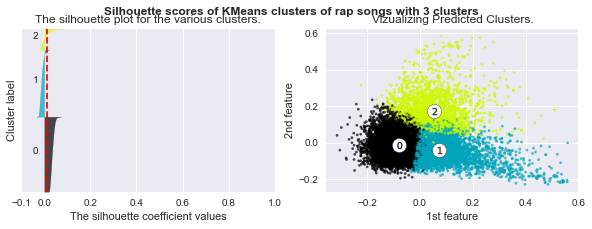

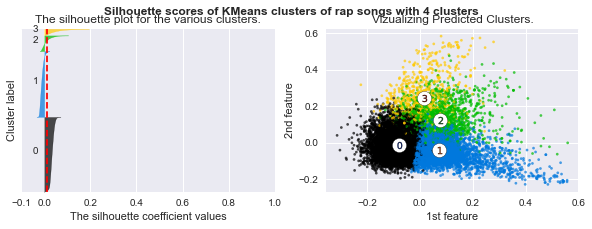

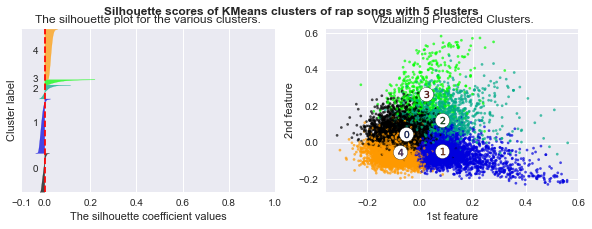

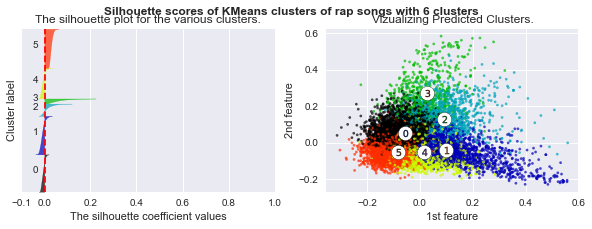

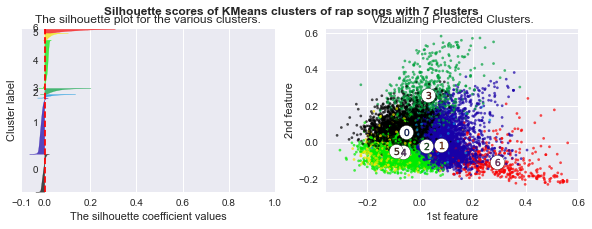

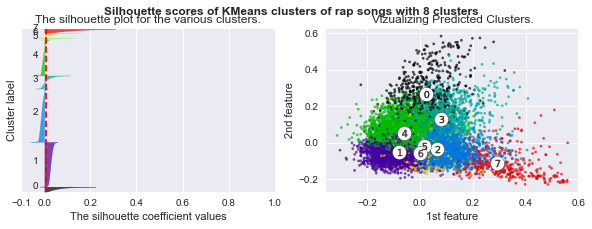

In [72]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
n_clus = range(3,9)
for clus in n_clus:
    km2 = KMeans(n_clusters=clus, max_iter=300, n_init=1, algorithm = 'full', random_state=3).fit(X_2)
    labels= km2.predict(X_2)
    silhouette_avg = silhouette_score(X_2, labels)
    print(f"For {clus} clusters, the average silhouette_score is : {silhouette_avg}\n")
    sample_sil_values = silhouette_samples(X_2, labels)
    means_lst = []
    for label in range(clus):
        means_lst.append(sample_sil_values[labels == label].mean())
    print(f"For {clus} clusters, the mean of each cluster is: {means_lst}\n")
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)

    # First subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_2) + (clus + 1) * 10])
    y_lower = 10
    
    for i in range(clus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        i_clus_values = \
            sample_sil_values[labels == i]

        i_clus_values.sort()

        size_cluster_i = i_clus_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clus)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, i_clus_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Second plot showing the actual clusters formed with the first two features
    colors = cm.nipy_spectral(labels.astype(float) / clus)
    ax2.scatter(X_2[:, 0], X_2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = km2.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Vizualizing Predicted Clusters.")
    ax2.set_xlabel("1st feature")
    ax2.set_ylabel("2nd feature")

    plt.suptitle(f"Silhouette scores of KMeans clusters of rap songs with {clus} clusters",
                 fontsize=12, fontweight='bold')

plt.show()

To read the charts above:
Each cluster is represented by a color. The silhouette plot on the left visualizes the silhouette score of each cluster using the x-axis as well as the size of the cluster using the thickness of each color. The closer the sihouette score is to 1, the better the cluster in terms of separation. The chart on the left visialuzes each cluster on a scatter plot with its first two features.

For the most part, the K-Means model did not yield good results, as all silhouette scores are nearly zero and clusters are very unequal. Usupervised learning for text classification is a rather difficult task as words in texts are coverted into a large number of features. Most clustering algorithms do not function well with a large amount of features when there are no labels to train on. This is known as the curse of dimensionality. In our case, reducing the number of features to, let's say, 10, would allow the model to cluster the data fairly well. However, reducing features so drastically would eliminate nearly all the information in the data, which would render the model ineffective. 

It looks like the optimal number of clusters is 4 as it has a (relatively) higher mean silhouette score. 

In [73]:
clus_final = 4
km_final = KMeans(n_clusters=clus_final, max_iter=300, n_init=1, algorithm = 'full', random_state=3).fit(X_2)
labels= km_final.predict(X_2)
sample_silhouette_values = silhouette_samples(X_2, labels)
means_lst_final = []
for label in range(clus_final):
    means_lst_final.append(sample_silhouette_values[labels == label].mean())

In [74]:
#adding predicted labels to the dataframe
df['cluster'] = pd.Series(km_final.predict(X_2), index=df.index)

## Cluster Analysis

After determining the number of clusters to split the dataset into, we can examine the differences between each of them. We can first plot the most common words in each cluster.

In [75]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means] 
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 4))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h', data = dfs[i][:n_feats])
        plt.xticks(fontsize=10)
        plt.show()

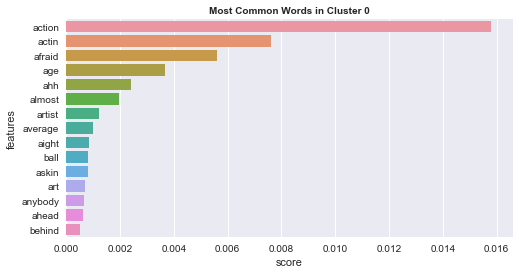

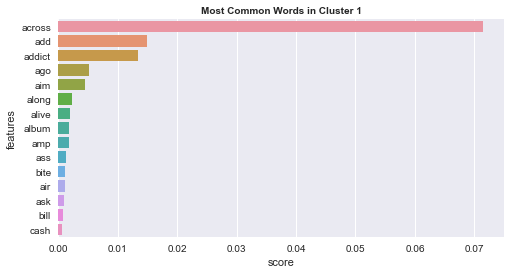

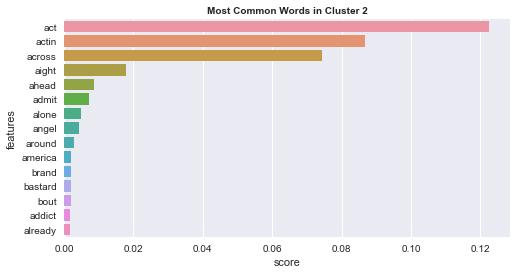

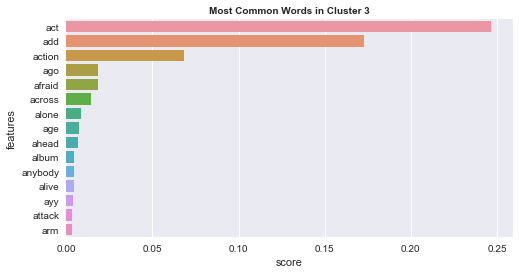

In [76]:
prediction = km_final.predict(X_2)
n_feats = 15
dfs = get_top_features_cluster(X_2, prediction, n_feats)
plotWords(dfs, n_feats)

As expected, given the low sihlouette scores, there is quite a bit of overlap of words between clusters. There does not seem to be clear lyric topics for each cluster. Next, we can examine the songs that are grouped into each cluster.

In [82]:
for clus in df['cluster'].unique():
    df_clus = df.loc[df['cluster'] == clus]
    print(f'Cluster No. {clus}')
    print(df_clus[['title', 'artist']].sample(8),'\n')

Cluster No. 0
                         title                artist
9112   Dj Chill Will Freestyle                 Big L
11379            Baggin' Crack               Raekwon
4581                   Goodbye                   DMX
16968                     Time         Ty Dolla $ign
11337  Marble Cake (Freestyle)               Raekwon
4911                 Digest It        Royce Da 5'9''
197                   Last Day  The Notorious B.I.G.
4893            Go Hard, Pt. 1        Royce Da 5'9'' 

Cluster No. 3
                               title       artist
10549                   Ain't Nobody    LL Cool J
2762                Man in the Night     Kid Cudi
1743                 The Crying Game  Nicki Minaj
16734               It's Complicated         Wale
16069                Never Made Love   Young Thug
4586                   The Prayer IV          DMX
3832       Don't Tell Me You Love Me     Big Sean
10589  Big Mama (Unconditional Love)    LL Cool J 

Cluster No. 1
                           

It may be difficult to discern the differences between the clusters by only looking at song names without knowing nearly every song in the dataset. Another option is to examine the distrubution of cluster labels across particular artists.

#### Distribution of Clusters for Different Artists
First we can look at the cluster distribution of the total song dataset.

Text(0.5, 1.0, 'Total Cluster Distribution')

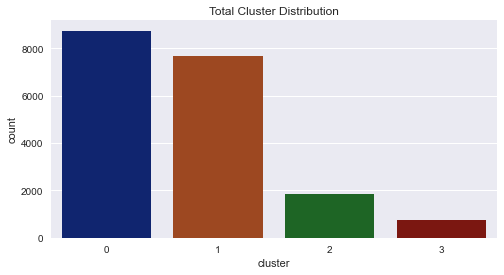

In [83]:
sns.set_palette('dark')
plt.figure(figsize=(8, 4))
sns.countplot(x='cluster', data=df).set_title('Total Cluster Distribution')

Text(0.5, 1.0, 'Artist Sample Group 1 Cluster Distribution')

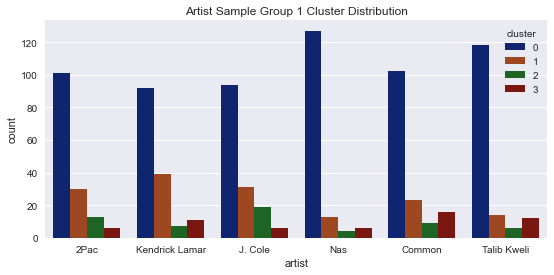

In [91]:
artists_1 = ['J. Cole', 'Kendrick Lamar', '2Pac', 'Talib Kweli', 'Common', 'Nas'] 

artist_clus_1 = df[df['artist'].isin(artists_1)]
plt.figure(figsize=(9, 4))
sns.countplot(x='artist', hue='cluster', data=artist_clus_1).set_title('Artist Sample Group 1 Cluster Distribution')

Text(0.5, 1.0, 'Artist Sample Group 2 Cluster Distribution')

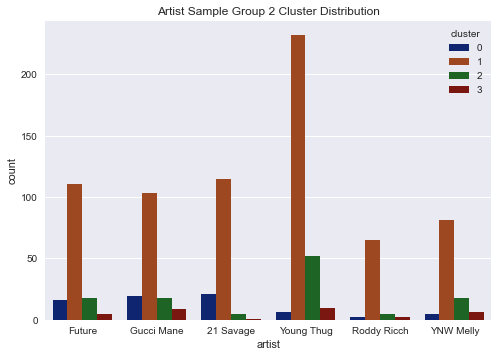

In [92]:
artists_2 = ['Future', 'Young Thug', 'Roddy Ricch', 'YNW Melly', '21 Savage', 'Gucci Mane']

artist_clus_2 = df[df['artist'].isin(artists_2)]
sns.countplot(x='artist', hue='cluster', data=artist_clus_2).set_title('Artist Sample Group 2 Cluster Distribution')

We can see that the distribution of clusters vary from artist to artist. This can mean that each artist focuses on different topics to rap about in their songs. 

In the first group of artists, I picked rappers that were more conscious, whose songs are generally more meaningful. Many of their songs speak on societal topics such as: working hard to achieve a dream, living in poverty in America, and the systemic racism that black people currently face. These artists tend to have more songs in the 0 and 3 clusters.

In the second group of artists, I picked rappers that were more mainstream in recent years. Their songs are the usual hits with catchy beats that are playing on the radio. The topics in these songs are the generic "money, women, drugs," which are hyper-marketed by the media. These artists tend to have their songs primarily in the 1 cluster.

There looks to be a clear difference in cluster labels for the two groups of artists. Although we were not able to determine the topics of each cluster by analyzing frequent words, we can see clear differences between them by examining the actual songs grouped and the cluster distrubution for various artists. This suggests that the K-Means model was successful to some extent in classifying the songs.